In [1]:
%cd /Users/lucie/Documents/PycharmProjects/DataAnalytics

/Users/lucie/Documents/PycharmProjects/DataAnalytics


In [2]:
import pandas as pd
import glob
import os
import random
from os import path

import dask
import joblib as jl
import matplotlib.pyplot as plt
import rasterio as rio
from dask import diagnostics
from scipy import ndimage as ndi
from rasterio import plot

import detectree as dtr
from detectree import filters, image_descriptor, pixel_features 

figwidth, figheight = plt.rcParams['figure.figsize']
%matplotlib inline

First, take a look at the tiles from zürich, from which the classifier has been trained. 

In [3]:
%%bash
ls -l data/interim/tiles/*.tif | head

-rw-r--r--  1 lucie  staff   88828 Apr 23 10:32 data/interim/tiles/1091-124_00.tif
-rw-r--r--  1 lucie  staff   89787 Apr 23 10:32 data/interim/tiles/1091-124_01.tif
-rw-r--r--  1 lucie  staff   97864 Apr 23 10:32 data/interim/tiles/1091-124_02.tif
-rw-r--r--  1 lucie  staff  126127 Apr 23 10:32 data/interim/tiles/1091-124_03.tif
-rw-r--r--  1 lucie  staff  135219 Apr 23 10:32 data/interim/tiles/1091-124_04.tif
-rw-r--r--  1 lucie  staff   93661 Apr 23 10:32 data/interim/tiles/1091-124_05.tif
-rw-r--r--  1 lucie  staff   93043 Apr 23 10:32 data/interim/tiles/1091-124_06.tif
-rw-r--r--  1 lucie  staff  100158 Apr 23 10:32 data/interim/tiles/1091-124_07.tif
-rw-r--r--  1 lucie  staff  111405 Apr 23 10:32 data/interim/tiles/1091-124_08.tif
-rw-r--r--  1 lucie  staff  140546 Apr 23 10:32 data/interim/tiles/1091-124_09.tif


In [4]:
%%bash
ls data/interim/tiles/*.tif | wc -w

     350


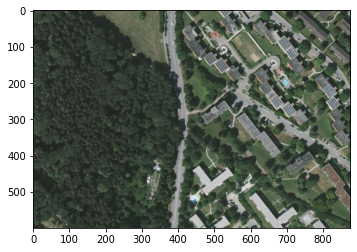

In [5]:
img_filepath = random.choice(glob.glob('data/interim/tiles/*.tif'))

with rio.open(img_filepath) as src:
    plot.show(src.read())

In [6]:
pfb = pixel_features.PixelFeaturesBuilder()

In [7]:
X = pfb.build_features_from_filepath(img_filepath)

In [8]:
X.shape

(525000, 27)

In [9]:
kernels = filters.get_gabor_filter_bank(frequencies=(.1, .25, .4),
                                        num_orientations=(4, 8, 8))
response_bins_per_axis = 4
num_color_bins = 8

img_descr = image_descriptor.compute_image_descriptor_from_filepath(
    img_filepath,
    kernels=kernels,
    response_bins_per_axis=response_bins_per_axis,
    num_color_bins=num_color_bins)

In [10]:
img_descr.shape

(832,)

In [11]:
img_dir = 'data/interim/tiles'

ts = dtr.TrainingSelector(img_dir=img_dir)

The split_df has already been defined and was stored in a csv file. The split_df was defined by:
split_df, evr = ts.train_test_split(method='cluster-II',
                                    num_components=24,
                                    return_evr=True)

In [12]:
split_df = pd.read_csv('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/interim/tiles/split.csv')
split_df[split_df['train']]

Unnamed: 0                        img_filepath  img_cluster  train
13           13  data/interim/tiles/1091-234_12.tif            1   True
30           30  data/interim/tiles/1091-413_24.tif            2   True
156         156  data/interim/tiles/1091-431_20.tif            3   True
268         268  data/interim/tiles/1091-231_02.tif            1   True
298         298  data/interim/tiles/1091-234_18.tif            0   True
330         330  data/interim/tiles/1091-233_16.tif            0   True

In [13]:
evr = 0.922583197079706

In [14]:
ts.descr_feature_matrix

[########################################] | 100% Completed | 15min 21.2s


array([[0.0022741 , 0.00218478, 0.00247958, ..., 0.        , 0.        ,
        0.        ],
       [0.00155026, 0.00156107, 0.00258304, ..., 0.        , 0.        ,
        0.        ],
       [0.00183955, 0.00190807, 0.00239117, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00180111, 0.00187403, 0.00174886, ..., 0.        , 0.        ,
        0.        ],
       [0.00226883, 0.00181441, 0.002178  , ..., 0.        , 0.        ,
        0.        ],
       [0.00231012, 0.00196371, 0.00203684, ..., 0.        , 0.        ,
        0.        ]])

The Zürich tiles already have response tiles for each of the training tiles that tell which of the pixels belong to a tree. They have been downloaded to the following repository: 

In [15]:
!ls -l data/interim/response_tiles/*.tif

-rw-r--r--  1 lucie  staff  525768 Apr 30 21:42 data/interim/response_tiles/1091-231_02.tif
-rw-r--r--  1 lucie  staff  525768 Apr 30 21:51 data/interim/response_tiles/1091-233_16.tif
-rw-r--r--  1 lucie  staff  525768 Apr 30 21:37 data/interim/response_tiles/1091-234_12.tif
-rw-r--r--  1 lucie  staff  525768 Apr 30 21:49 data/interim/response_tiles/1091-234_18.tif
-rw-r--r--  1 lucie  staff  528393 Apr 30 21:38 data/interim/response_tiles/1091-413_24.tif
-rw-r--r--  1 lucie  staff  528393 Apr 30 21:38 data/interim/response_tiles/1091-431_20.tif


The response tiles provide ground truth masks for the training tiles:

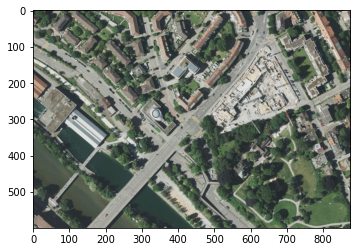

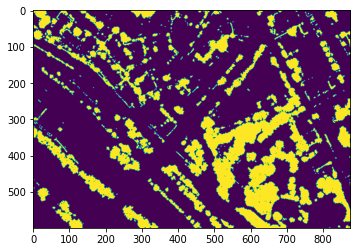

In [17]:
response_dir = 'data/interim/response_tiles'

img_filepath = split_df[split_df['train']]['img_filepath'].sample(1).iloc[0]
response_filepath = path.join(response_dir, path.basename(img_filepath))

for filepath in [img_filepath, response_filepath]:
    with rio.open(filepath) as src:
        plot.show(src.read())

In [18]:
split_df[split_df['train']]

Unnamed: 0                        img_filepath  img_cluster  train
13           13  data/interim/tiles/1091-234_12.tif            1   True
30           30  data/interim/tiles/1091-413_24.tif            2   True
156         156  data/interim/tiles/1091-431_20.tif            3   True
268         268  data/interim/tiles/1091-231_02.tif            1   True
298         298  data/interim/tiles/1091-234_18.tif            0   True
330         330  data/interim/tiles/1091-233_16.tif            0   True

The trained classifier as also alredy been stored: 

In [19]:
models_dir = 'models'

In [20]:
from joblib import dump, load
img_cluster_0 = load('models/0.joblib')
img_cluster_1 = load('models/1.joblib')
img_cluster_2 = load('models/2.joblib')
img_cluster_3 = load('models/3.joblib')

In [21]:
clf_dict = {0: img_cluster_0, 1: img_cluster_1, 2: img_cluster_2, 3: img_cluster_3}
clf_dict

{0: AdaBoostClassifier(n_estimators=200),
 1: AdaBoostClassifier(n_estimators=200),
 2: AdaBoostClassifier(n_estimators=200),
 3: AdaBoostClassifier(n_estimators=200)}

Now to the innsbruck tiles: 

In [59]:
%%bash
ls -l data/raw/ibk_tiles/*.tif | head

-rw-r--r--  1 lucie  staff  16677 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_00.tif
-rw-r--r--  1 lucie  staff  17255 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_01.tif
-rw-r--r--  1 lucie  staff  14814 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_02.tif
-rw-r--r--  1 lucie  staff  14350 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_03.tif
-rw-r--r--  1 lucie  staff  16497 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_04.tif
-rw-r--r--  1 lucie  staff  13309 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_05.tif
-rw-r--r--  1 lucie  staff  13236 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_06.tif
-rw-r--r--  1 lucie  staff  12965 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_07.tif
-rw-r--r--  1 lucie  staff  15662 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_08.tif
-rw-r--r--  1 lucie  staff  16523 Apr 22 16:47 data/raw/ibk_tiles/dop_2424-17_2019_09.tif


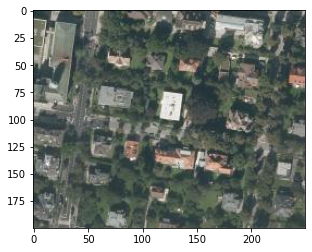

In [60]:
ibk_img_filepath = random.choice(glob.glob('data/raw/ibk_tiles/*.tif'))

with rio.open(ibk_img_filepath) as src:
    plot.show(src.read())

In [61]:
%%bash
ls data/raw/ibk_tiles/*.tif | wc -w

      25


In [22]:
ibk_split_df = pd.read_csv('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/raw/ibk_tiles/split.csv')
ibk_split_df.pop('Unnamed: 0')
ibk_split_df

img_filepath  img_cluster  train
0   data/raw/ibk_tiles/dop_2424-17_2019_15.tif            3  False
1   data/raw/ibk_tiles/dop_2424-17_2019_01.tif            0  False
2   data/raw/ibk_tiles/dop_2424-17_2019_00.tif            3  False
3   data/raw/ibk_tiles/dop_2424-17_2019_14.tif            0   True
4   data/raw/ibk_tiles/dop_2424-17_2019_02.tif            3  False
5   data/raw/ibk_tiles/dop_2424-17_2019_16.tif            3  False
6   data/raw/ibk_tiles/dop_2424-17_2019_17.tif            2  False
7   data/raw/ibk_tiles/dop_2424-17_2019_03.tif            1  False
8   data/raw/ibk_tiles/dop_2424-17_2019_07.tif            0  False
9   data/raw/ibk_tiles/dop_2424-17_2019_13.tif            3  False
10  data/raw/ibk_tiles/dop_2424-17_2019_12.tif            3  False
11  data/raw/ibk_tiles/dop_2424-17_2019_06.tif            2  False
12  data/raw/ibk_tiles/dop_2424-17_2019_10.tif            2   True
13  data/raw/ibk_tiles/dop_2424-17_2019_04.tif            2  False
14  data/raw/ibk_tiles/dop_2424-17_2019_05.tif            1   True
15  data/raw/ibk_tiles/dop_2424-17_2019_11.tif            0  False
16  data/raw/ibk_tiles/dop_2424-17_2019_20.tif            3  False
17  data/raw/ibk_tiles/dop_2424-17_2019_08.tif            2  False
18  data/raw/ibk_tiles/dop_2424-17_2019_09.tif            3  False
19  data/raw/ibk_tiles/dop_2424-17_2019_21.tif            2  False
20  data/raw/ibk_tiles/dop_2424-17_2019_23.tif            2  False
21  data/raw/ibk_tiles/dop_2424-17_2019_22.tif            0  False
22  data/raw/ibk_tiles/dop_2424-17_2019_19.tif            2  False
23  data/raw/ibk_tiles/dop_2424-17_2019_24.tif            3   True
24  data/raw/ibk_tiles/dop_2424-17_2019_18.tif            2  False

In [24]:
split_df[split_df['train']]

Unnamed: 0                        img_filepath  img_cluster  train
13           13  data/interim/tiles/1091-234_12.tif            1   True
30           30  data/interim/tiles/1091-413_24.tif            2   True
156         156  data/interim/tiles/1091-431_20.tif            3   True
268         268  data/interim/tiles/1091-231_02.tif            1   True
298         298  data/interim/tiles/1091-234_18.tif            0   True
330         330  data/interim/tiles/1091-233_16.tif            0   True

In [25]:
clf_dict

{0: AdaBoostClassifier(n_estimators=200),
 1: AdaBoostClassifier(n_estimators=200),
 2: AdaBoostClassifier(n_estimators=200),
 3: AdaBoostClassifier(n_estimators=200)}

First classify the Zürich tiles:

In [26]:
# load a non-training tile
img_row = split_df[~split_df['train']].iloc[0]
img_filepath = img_row['img_filepath']
img_cluster = img_row['img_cluster']

# get the classifier of the tile's corresponding first-level cluster
clf = clf_dict[img_cluster]

# classify the tile
y_nonrefined = dtr.Classifier(refine=False).classify_img(img_filepath, clf)
# `refine=True` by default in `Classifier`
c = dtr.Classifier()
y = c.classify_img(img_filepath, clf)

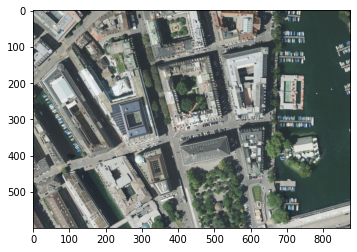

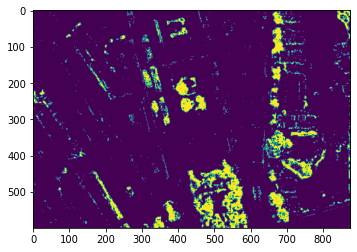

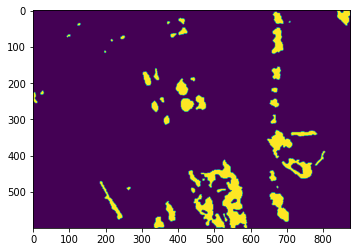

In [27]:
# open Zürich classifiaction 
with rio.open(img_filepath) as src:
    plot.show(src.read())

plt.imshow(y_nonrefined)
plt.figure()
plt.imshow(y)

Now try to find trees in the ibk-tiles, using the same classifier:

In [28]:
ibk_split_df

img_filepath  img_cluster  train
0   data/raw/ibk_tiles/dop_2424-17_2019_15.tif            3  False
1   data/raw/ibk_tiles/dop_2424-17_2019_01.tif            0  False
2   data/raw/ibk_tiles/dop_2424-17_2019_00.tif            3  False
3   data/raw/ibk_tiles/dop_2424-17_2019_14.tif            0   True
4   data/raw/ibk_tiles/dop_2424-17_2019_02.tif            3  False
5   data/raw/ibk_tiles/dop_2424-17_2019_16.tif            3  False
6   data/raw/ibk_tiles/dop_2424-17_2019_17.tif            2  False
7   data/raw/ibk_tiles/dop_2424-17_2019_03.tif            1  False
8   data/raw/ibk_tiles/dop_2424-17_2019_07.tif            0  False
9   data/raw/ibk_tiles/dop_2424-17_2019_13.tif            3  False
10  data/raw/ibk_tiles/dop_2424-17_2019_12.tif            3  False
11  data/raw/ibk_tiles/dop_2424-17_2019_06.tif            2  False
12  data/raw/ibk_tiles/dop_2424-17_2019_10.tif            2   True
13  data/raw/ibk_tiles/dop_2424-17_2019_04.tif            2  False
14  data/raw/ibk_tiles/dop_2424-17_2019_05.tif            1   True
15  data/raw/ibk_tiles/dop_2424-17_2019_11.tif            0  False
16  data/raw/ibk_tiles/dop_2424-17_2019_20.tif            3  False
17  data/raw/ibk_tiles/dop_2424-17_2019_08.tif            2  False
18  data/raw/ibk_tiles/dop_2424-17_2019_09.tif            3  False
19  data/raw/ibk_tiles/dop_2424-17_2019_21.tif            2  False
20  data/raw/ibk_tiles/dop_2424-17_2019_23.tif            2  False
21  data/raw/ibk_tiles/dop_2424-17_2019_22.tif            0  False
22  data/raw/ibk_tiles/dop_2424-17_2019_19.tif            2  False
23  data/raw/ibk_tiles/dop_2424-17_2019_24.tif            3   True
24  data/raw/ibk_tiles/dop_2424-17_2019_18.tif            2  False

In [45]:
# ibk_img_row = ibk_split_df.loc[['data/raw/ibk_tiles/dop_2424-17_2019_02.tif'], :]

loc = ibk_split_df[ibk_split_df['img_filepath'] == ibk_img_filepath]
ibk_img_cluster = loc['img_cluster'].values[0]
ibk_img_cluster

2

In [30]:
# ibk_img_filepath = 'data/raw/ibk_tiles/dop_2424-17_2019_09.tif'

In [31]:
# ibk_img_cluster = 1

In [33]:
# classify the ibk tile
y_nonrefined = dtr.Classifier(refine=False).classify_img(ibk_img_filepath, clf)
# `refine=True` by default in `Classifier`
c = dtr.Classifier()
y = c.classify_img(ibk_img_filepath, clf)


plot Innsbruck tile: 

In [52]:
# random: classify new york mapbox tile 
y_nonrefined = dtr.Classifier(refine=False).classify_img('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/raw/response-statc-tyout.jpeg', clf)
# `refine=True` by default in `Classifier`
c = dtr.Classifier()
y = c.classify_img('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/raw/response-statc-tyout.jpeg', clf)

/Users/lucie/Documents/PycharmProjects/DataAnalytics/dataanalytics/lib/python3.10/site-packages/rasterio/__init__.py:262: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


/Users/lucie/Documents/PycharmProjects/DataAnalytics/dataanalytics/lib/python3.10/site-packages/rasterio/__init__.py:262: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


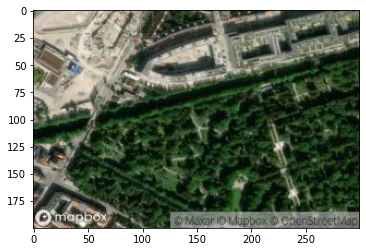

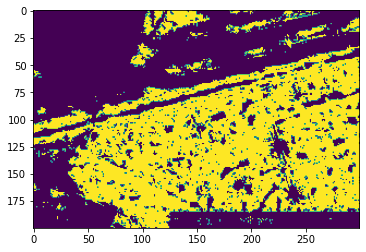

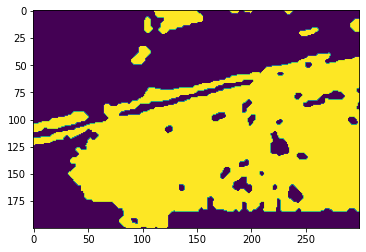

In [53]:
# random: open new york mapbox tile 
with rio.open('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/raw/response-statc-tyout.jpeg') as src:
    plot.show(src.read())

plt.imshow(y_nonrefined)
plt.figure()
plt.imshow(y)
picture = plt.imshow(y)

/Users/lucie/Documents/PycharmProjects/DataAnalytics/dataanalytics/lib/python3.10/site-packages/rasterio/__init__.py:262: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/lucie/Documents/PycharmProjects/DataAnalytics/dataanalytics/lib/python3.10/site-packages/rasterio/__init__.py:272: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


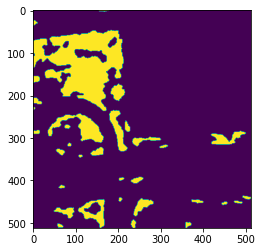

In [48]:
# save the new york random tile
output_dir = 'data/raw/ny_pred-tiles'

if not path.exists(output_dir):
    os.mkdir(output_dir)

pred_img_filepath = path.join(
                output_dir, path.basename('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/raw/response-2.jpeg')
            )
pred_tile = c.classify_img('/Users/lucie/Documents/PycharmProjects/DataAnalytics/data/raw/response-2.jpeg', clf, pred_img_filepath)
# ibk_sample_df = ibk_split_df[~ibk_split_df['train']].sample(20)
# pred_tile = c.classify_imgs(ibk_sample_df, output_dir, clf_dict=clf_dict)

picture = plt.imshow(y)



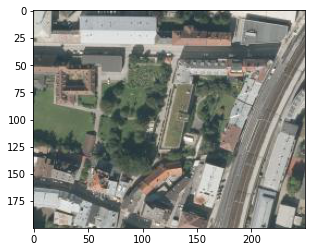

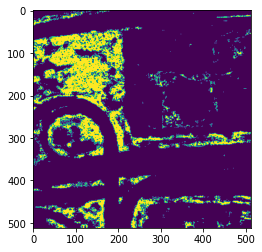

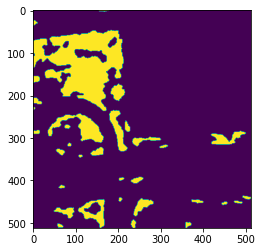

In [46]:
# open ibk classifiaction 
with rio.open(ibk_img_filepath) as src:
    plot.show(src.read())

plt.imshow(y_nonrefined)
plt.figure()
plt.imshow(y)
picture = plt.imshow(y)

In [35]:
output_dir = 'data/raw/ibk_pred-tiles'
if not path.exists(output_dir):
    os.mkdir(output_dir)

pred_img_filepath = path.join(
                output_dir, path.basename(ibk_img_filepath)
            )
pred_tile = c.classify_img(ibk_img_filepath, clf, pred_img_filepath)
# ibk_sample_df = ibk_split_df[~ibk_split_df['train']].sample(20)
# pred_tile = c.classify_imgs(ibk_sample_df, output_dir, clf_dict=clf_dict)
pred_tile

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
img_filepath_to_list = ibk_split_df['img_filepath'].tolist()
img_filepath_to_list

['data/raw/ibk_tiles/dop_2424-17_2019_15.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_01.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_00.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_14.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_02.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_16.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_17.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_03.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_07.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_13.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_12.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_06.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_10.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_04.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_05.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_11.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_20.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_08.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_09.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_21.tif',
 'data/raw/ibk_tiles/dop_2424-17_2019_23.tif',
 'data/raw/ib

data/raw/ibk_tiles/dop_2424-17_2019_15.tif


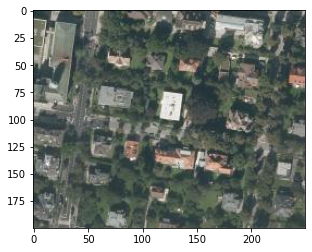

data/raw/ibk_tiles/dop_2424-17_2019_01.tif


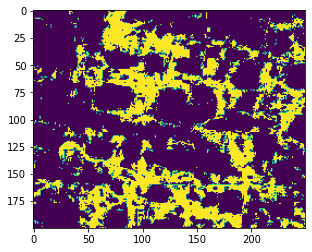

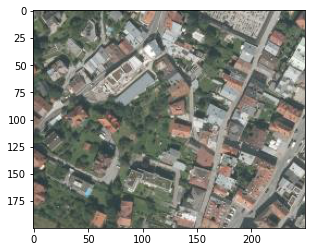

data/raw/ibk_tiles/dop_2424-17_2019_00.tif


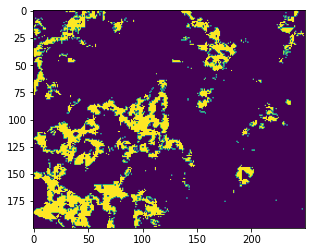

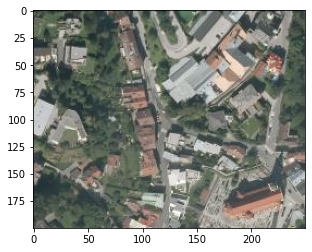

data/raw/ibk_tiles/dop_2424-17_2019_14.tif


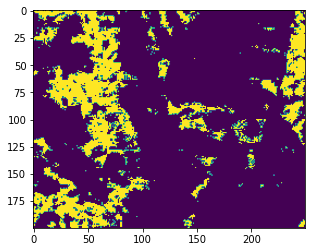

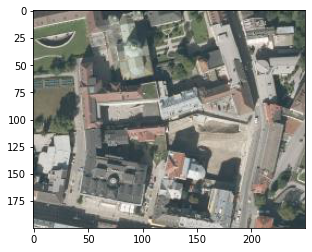

data/raw/ibk_tiles/dop_2424-17_2019_02.tif


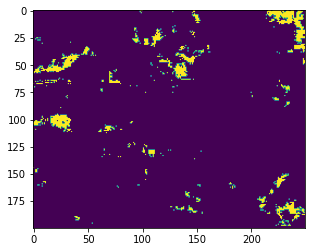

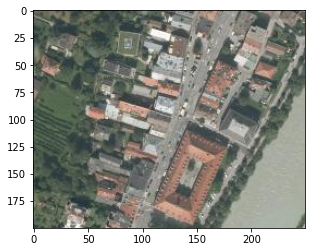

data/raw/ibk_tiles/dop_2424-17_2019_16.tif


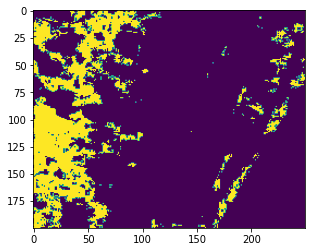

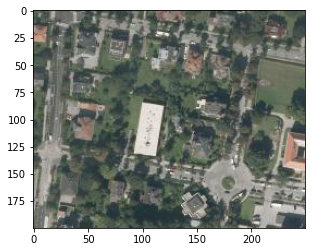

data/raw/ibk_tiles/dop_2424-17_2019_17.tif


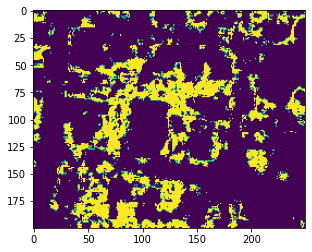

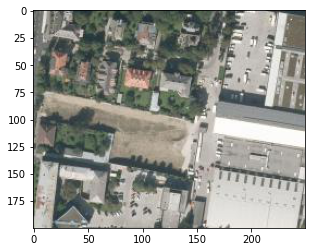

data/raw/ibk_tiles/dop_2424-17_2019_03.tif


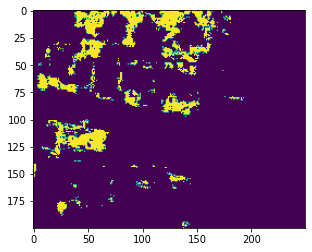

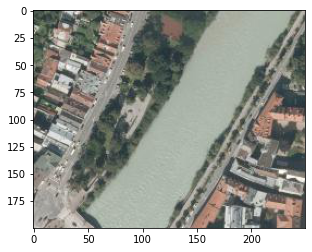

data/raw/ibk_tiles/dop_2424-17_2019_07.tif


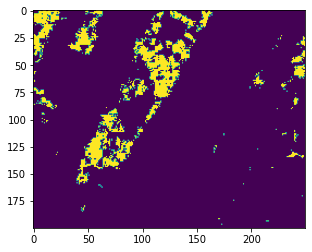

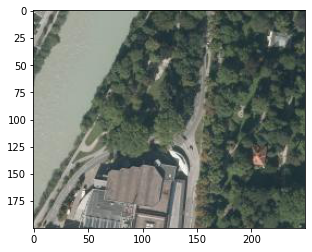

data/raw/ibk_tiles/dop_2424-17_2019_13.tif


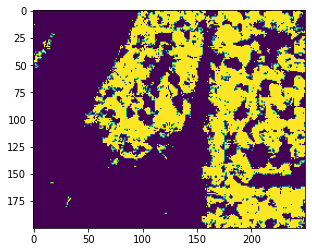

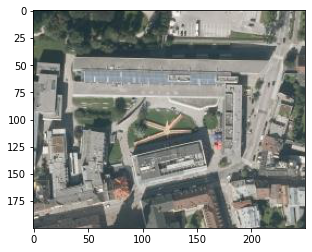

data/raw/ibk_tiles/dop_2424-17_2019_12.tif


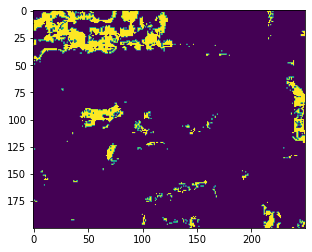

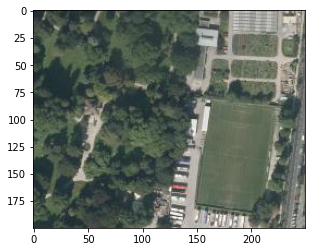

data/raw/ibk_tiles/dop_2424-17_2019_06.tif


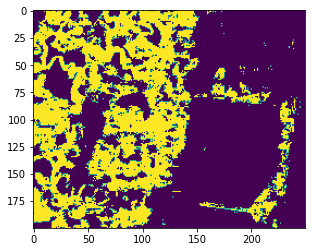

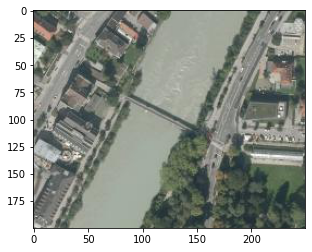

data/raw/ibk_tiles/dop_2424-17_2019_10.tif


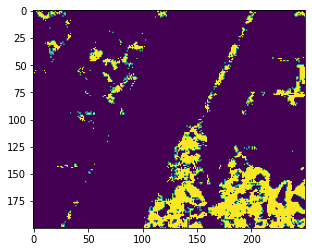

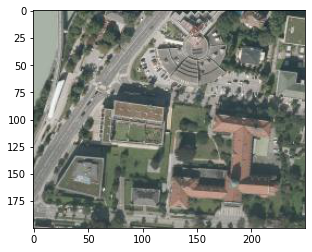

data/raw/ibk_tiles/dop_2424-17_2019_04.tif


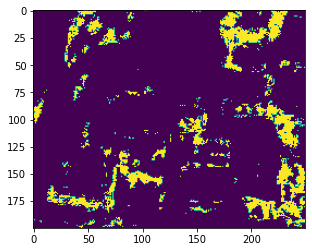

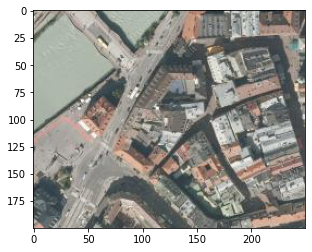

data/raw/ibk_tiles/dop_2424-17_2019_05.tif


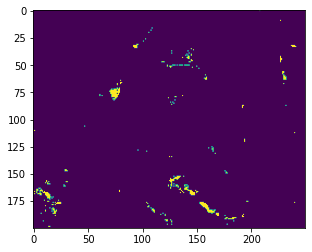

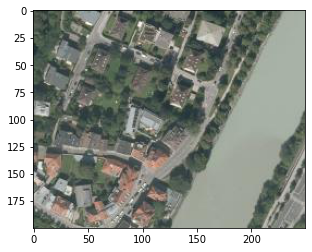

data/raw/ibk_tiles/dop_2424-17_2019_11.tif


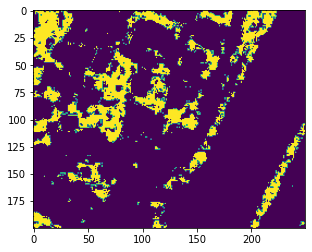

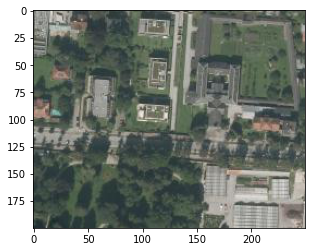

data/raw/ibk_tiles/dop_2424-17_2019_20.tif


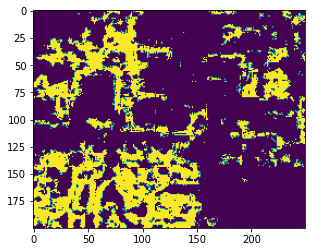

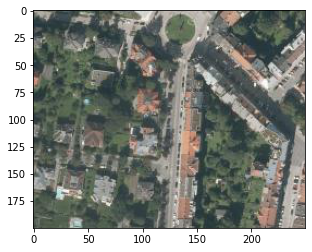

data/raw/ibk_tiles/dop_2424-17_2019_08.tif


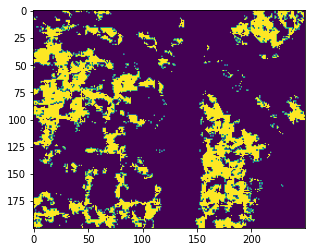

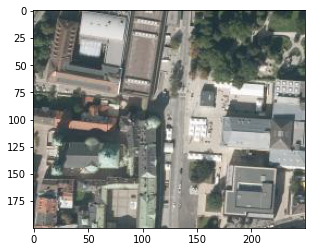

data/raw/ibk_tiles/dop_2424-17_2019_09.tif


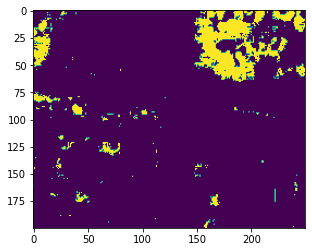

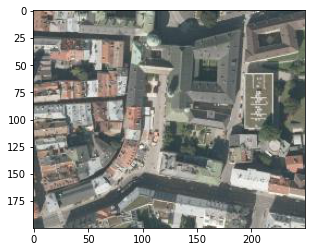

data/raw/ibk_tiles/dop_2424-17_2019_21.tif


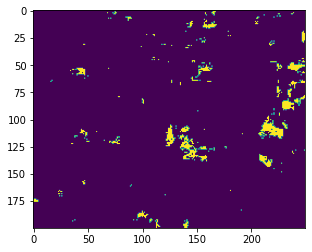

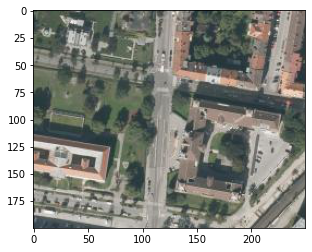

data/raw/ibk_tiles/dop_2424-17_2019_23.tif


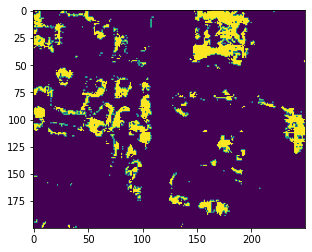

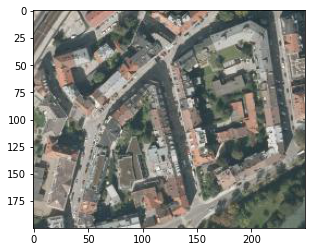

data/raw/ibk_tiles/dop_2424-17_2019_22.tif


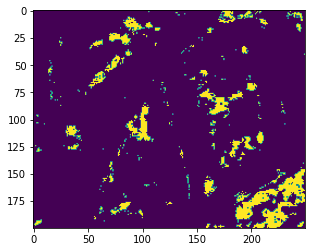

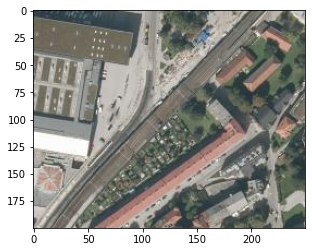

data/raw/ibk_tiles/dop_2424-17_2019_19.tif


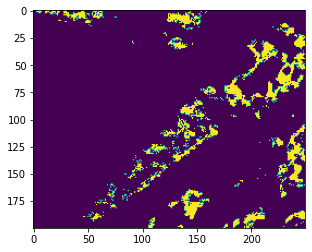

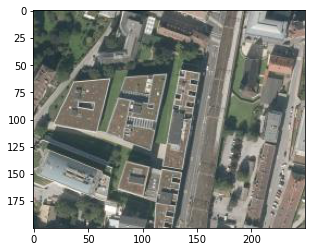

data/raw/ibk_tiles/dop_2424-17_2019_24.tif


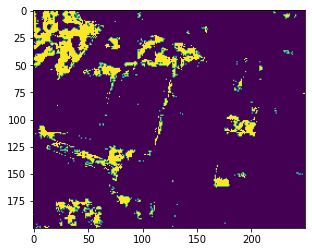

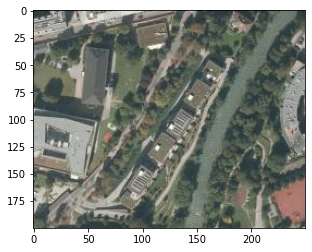

data/raw/ibk_tiles/dop_2424-17_2019_18.tif


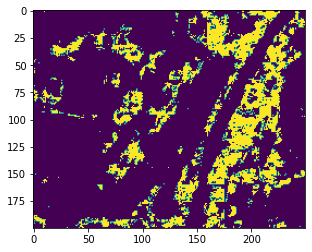

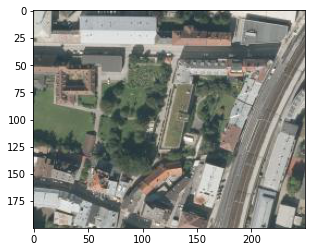

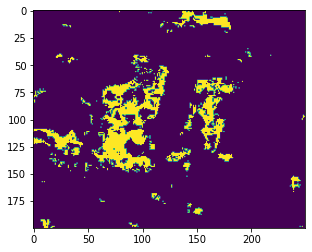

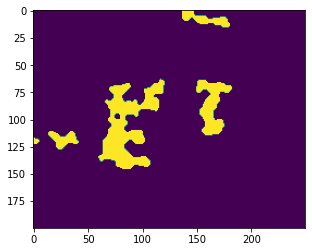

In [37]:
for ibk_img_filepath in img_filepath_to_list:
    print(ibk_img_filepath)
    row = ibk_split_df[ibk_split_df['img_filepath'] == ibk_img_filepath]
    ibk_img_cluster = row['img_cluster'].values[0]
    y_nonrefined = dtr.Classifier(refine=False).classify_img(ibk_img_filepath, clf)
    # `refine=True` by default in `Classifier`
    c = dtr.Classifier()
    y = c.classify_img(ibk_img_filepath, clf)
    with rio.open(ibk_img_filepath) as src:
        plot.show(src.read())

    plt.imshow(y_nonrefined)
    plt.figure()
    plt.imshow(y)
    picture = plt.imshow(y)
    pred_img_filepath = path.join(
                output_dir, path.basename(ibk_img_filepath)
            )
    pred_tile = c.classify_img(ibk_img_filepath, clf, pred_img_filepath)


In [241]:
import os
 
# Get the list of all files and directories
path = "data/raw/ibk_pred-tiles"
pred_tiles = os.listdir(path)
 
print("Files and directories in '", path, "' :")
 
# prints all files
print(pred_tiles)

Files and directories in ' data/raw/ibk_pred-tiles ' :
['dop_2424-17_2019_15.tif', 'dop_2424-17_2019_01.tif', 'dop_2424-17_2019_00.tif', 'dop_2424-17_2019_14.tif', 'dop_2424-17_2019_02.tif', 'dop_2424-17_2019_16.tif', '.DS_Store', 'dop_2424-17_2019_17.tif', 'dop_2424-17_2019_03.tif', 'dop_2424-17_2019_07.tif', 'dop_2424-17_2019_13.tif', 'dop_2424-17_2019_12.tif', 'dop_2424-17_2019_06.tif', 'dop_2424-17_2019_10.tif', 'dop_2424-17_2019_04.tif', 'dop_2424-17_2019_05.tif', 'dop_2424-17_2019_11.tif', 'dop_2424-17_2019_20.tif', 'dop_2424-17_2019_08.tif', 'dop_2424-17_2019_09.tif', 'dop_2424-17_2019_21.tif', 'dop_2424-17_2019_23.tif', 'dop_2424-17_2019_22.tif', 'dop_2424-17_2019_19.tif', 'dop_2424-17_2019_24.tif', 'dop_2424-17_2019_18.tif']


In [243]:
from rasterio import merge
canopy_tiles = pred_tiles 

canopy_arr, canopy_transform = merge.merge(
    [rio.open(canopy_tile) for canopy_tile in canopy_tiles])

RasterioIOError: dop_2424-17_2019_15.tif: No such file or directory